In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Read database

In [30]:
dbfile = 'os-sqlite3-data/database.db'
table_name = 'selected_books'
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df = pd.read_sql_query(query, connection)
df.head()

,id,title,authors,year,isbn,is_found,labels_set,search_count,search_terms,search_begin_time_utc,search_end_time_utc,search_abandon_time_utc,uid
0,1,Epätavallinen lukija,,NaN,NaN,0,a,5,None,2023-09-15T12:43:19.266Z,None,2023-09-15T12:46:26.156Z,14baaffb-7b19-4af2-80c2-7e1f2e819d8e
1,2,Jane Austen -lukupiiri,"Fowler, Karen Joy",2005.0,9.789512e+12,1,a,3,"lukeminen, ihmissuhteet,",2023-09-15T12:43:19.266Z,2023-09-15T12:51:24.937Z,None,14baaffb-7b19-4af2-80c2-7e1f2e819d8e
2,3,Liian meluisa yksinäisyys,"Hrabal, Bohumil",2008.0,9.789512e+12,1,a,4,"kirjat, paperinkeräys,",2023-09-15T12:43:19.266Z,2023-09-15T13:02:26.617Z,None,14baaffb-7b19-4af2-80c2-7e1f2e819d8e
3,4,Elämän mittainen lukupiiri,,NaN,NaN,0,a,9,None,2023-09-15T13:05:20.090Z,None,2023-09-15T13:07:22.046Z,14baaffb-7b19-4af2-80c2-7e1f2e819d8e
4,5,Kenkähullun matka,"Arvola, Oiva",2005.0,9.789512e+12,1,a,4,"jalkineet,",2023-09-15T13:22:22.305Z,2023-09-15T13:24:47.479Z,None,14baaffb-7b19-4af2-80c2-7e1f2e819d8e


In [31]:
df.columns

Index(['id', 'title', 'authors', 'year', 'isbn', 'is_found', 'labels_set',
       'search_count', 'search_terms', 'search_begin_time_utc',
       'search_end_time_utc', 'search_abandon_time_utc', 'uid'],
      dtype='object')

In [32]:
# Convert timestamps in string format to datetime
df['search_begin_time_utc'] = pd.to_datetime(df['search_begin_time_utc'])
df['search_end_time_utc'] = pd.to_datetime(df['search_end_time_utc'])
df['search_abandon_time_utc'] = pd.to_datetime(df['search_abandon_time_utc'])

# Calculate durations in seconds
df['duration_to_find'] = (df['search_end_time_utc'] - df['search_begin_time_utc']).dt.total_seconds()
df['duration_to_abandon'] = (df['search_abandon_time_utc'] - df['search_begin_time_utc']).dt.total_seconds()

## Results

In [41]:
df[['uid', 'title']].nunique()

uid       2
title    18
dtype: int64

In [34]:
df.groupby(by='labels_set')[['is_found', 'search_count']].sum()

,is_found,search_count
labels_set,,
a,10,47
b,6,58


In [35]:
df.groupby(by='labels_set')[['is_found', 'duration_to_find', 'duration_to_abandon', 'search_count']].mean()

,is_found,duration_to_find,duration_to_abandon,search_count
labels_set,,,,
a,0.588235,425.5691,289.9870,2.764706
b,0.333333,679.6615,362.9915,3.222222


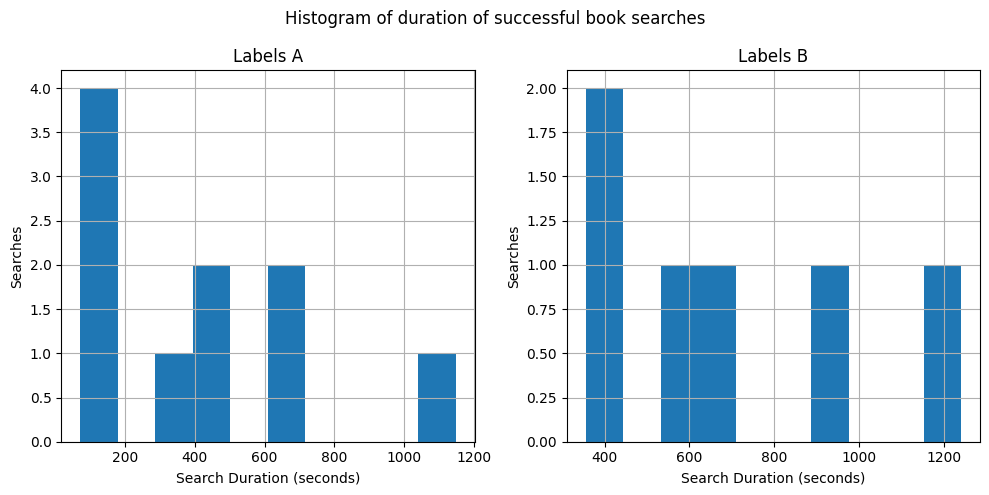

In [36]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = list(range(0, 300, 20))

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df[df.labels_set == 'a'].duration_to_find.hist()  # bins=bins)
plt.xlabel('Search Duration (seconds)')
plt.ylabel('Searches')
plt.title('Labels A')

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df[df.labels_set == 'b'].duration_to_find.hist() # bins=bins)
plt.xlabel('Search Duration (seconds)')
plt.ylabel('Searches')
plt.title('Labels B')

plt.suptitle('Histogram of duration of successful book searches')
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

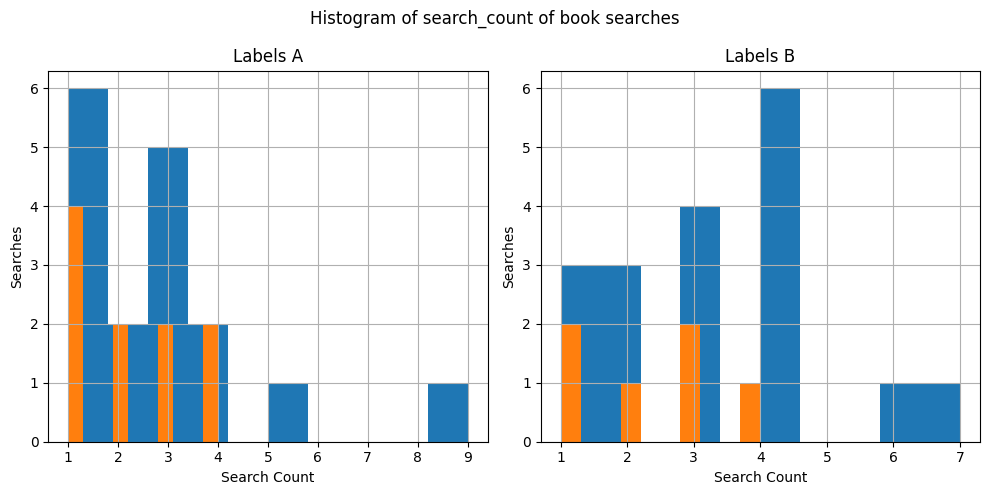

In [37]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
# bins = list(range(0, 300, 20))

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df[(df.labels_set == 'a')].search_count.hist()  # bins=bins)
df[(df.labels_set == 'a') & (df.is_found)].search_count.hist()  # bins=bins)
plt.xlabel('Search Count')
plt.ylabel('Searches')
plt.title('Labels A')

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df[df.labels_set == 'b'].search_count.hist()  # bins=bins)
df[(df.labels_set == 'b') & (df.is_found)].search_count.hist()  # bins=bins)
plt.xlabel('Search Count')
plt.ylabel('Searches')
plt.title('Labels B')

plt.suptitle('Histogram of search_count of book searches')
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

In [38]:
df.groupby(by='labels_set').agg({
    "is_found": 'mean',
    "duration_to_find": 'mean',
    "duration_to_abandon": 'mean',})

,is_found,duration_to_find,duration_to_abandon
labels_set,,,
a,0.588235,425.5691,289.9870
b,0.333333,679.6615,362.9915
